In [0]:
#@title Mount drive to colab
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
#@title Imports
import os
import math
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold

dirname = "/content/gdrive/My Drive/Emotion Research/"
os.chdir(dirname)
dtype = torch.float
device = torch.device("cuda:0")

emotions = ['happiness', 'sadness', 'anger', 'disgust', 'surprise', 'fear']#, 'mixed emotion']#, 'no emotion']

#STANFORD TOKENIZER SERVER

In [0]:
#@title Install Java
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()
os.chdir(dirname + "stanford-corenlp-full-2018-02-27")
!pwd

openjdk version "11.0.3" 2019-04-16
OpenJDK Runtime Environment (build 11.0.3+7-Ubuntu-1ubuntu218.04.1)
OpenJDK 64-Bit Server VM (build 11.0.3+7-Ubuntu-1ubuntu218.04.1, mixed mode, sharing)
/content/gdrive/My Drive/Emotion Research/stanford-corenlp-full-2018-02-27


In [0]:
#@title Start Stanford Tokenizer Server
%%bash --bg
nohup java -mx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -preload tokenize,ssplit -status_port 9080 -port 9080 -timeout 15000

Starting job # 0 in a separate thread.


In [0]:
os.chdir(dirname)

#LOAD VECTORS

##GloVe

In [0]:
#@title Read GloVe Vectors
import _pickle as cPickle
start_time = time.time()
with open(dirname + "Pickle/gloveModel", 'rb') as infile:
    gloveModel = cPickle.load(infile)
print("--- %s seconds ---" % (time.time() - start_time))

glove_used = True

--- 89.51689434051514 seconds ---


##fastText

In [0]:
#@title Install fastText

start_time = time.time()
os.chdir(dirname + "fastText")
!git pull
!pip install .
os.chdir(dirname)
import fastText
print("--- %s seconds ---" % (time.time() - start_time))

In [0]:
#@title Read fastText Model
start_time = time.time()
fastTextmodel = fastText.load_model(dirname + "Pickle/crawl-300d-2M-subword.bin")
print("--- %s seconds ---" % (time.time() - start_time))

glove_used = False

#LOAD DATASET AND TARGETS

In [0]:
#@title Read Dataset
#["s_aman data", "s_aman data + our data", "s_aman data cleared", "s_aman data cleared + our data"]
import _pickle as cPickle

start_time = time.time()
with open(dirname + "Pickle/lc data/s_aman data", 'rb') as infile:
    dataset = cPickle.load(infile)
print("--- %s seconds ---" % (time.time() - start_time))
print(len(dataset))

--- 0.5608303546905518 seconds ---
4639


In [0]:
#@title Dataset Shuffle
from random import shuffle
shuffle(dataset)

In [0]:
#@title Filter out not needed data points
# [536, 173, 179, 172, 115, 115, 176, 2800]
counter = [0] * 8
filtereddata = []
for data in dataset:
    counter[data[0]] += 1
    if data[0] == 7 or data[0] == 6:
        continue
    filtereddata.append(data)
print(len(filtereddata))
print(counter)

8227
[2056, 1677, 1560, 1252, 278, 1404, 176, 2800]


#FUNCTION DEFINITIONS

In [0]:
#@title Plotting Function Definitions

import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import pandas as pd
from io import BytesIO
from PIL import Image, ImageFont, ImageDraw
from IPython import display

pd.options.display.float_format = '{:.3f}'.format

# https://stackoverflow.com/a/43647344
# SET FONT FOR MATPLOTLIB
font_dirs = [dirname + 'fonts/', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)
plt.rcParams['font.family'] = 'Source Code Pro'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'

# SET FONT FOR PIL
font = ImageFont.truetype(dirname + 'fonts/' + 'SourceCodePro-Black.ttf', 25)

#https://datascience.stackexchange.com/a/31311
def report_average(reports, emotions):
    report_list = []
    for report in reports:
        splited = [' '.join(x.split()) for x in report.split('\n\n')]
        header = [x for x in splited[0].split(' ')]
        data = np.array(splited[1].split(' ')).reshape(-1, len(header) + 1)
        data = np.delete(data, 0, 1).astype(float)
        avgfilter = [False,False,True,True,True,True,False,False,True,True,True,True,False,False,True,True,True,True]
        averages = np.array(splited[2].split(' '))[avgfilter].reshape(-1, len(header)).astype(float)
        df = pd.DataFrame(np.concatenate((data, averages)), columns=header)
        report_list.append(df)
    res = pd.concat(report_list).groupby(level=0).mean()
    indexes = emotions + ["", "micro avg", "macro avg", "weighted avg"]

    line = pd.DataFrame([[np.nan,np.nan,np.nan,np.nan]], columns=res.columns.values)
    res = pd.concat([res.iloc[:len(emotions)], line, res.iloc[len(emotions):]])

    res.index = indexes
    res = res.replace(np.nan,'')

    return res.to_string()

# https://stackoverflow.com/a/35599851
def plot_confusion_matrix(cm, target_names, train):
    title='\ confusion\ matrix'
    cmap=plt.cm.YlGn
    plt.figure(figsize=[5, 4])
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(r"$\bf{" + (("train" + title) if train else ("test" + title)) + "}$")
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.grid(False)

    width, height = cm.shape
    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    buffer = BytesIO()
    plt.savefig(buffer, format='png', dpi = 125)
    plt.close()
    
    return buffer

def plottraintest(trainlosses, testlosses):
    #display.clear_output(wait=True)

    plt.figure(figsize=[10, 5])
    
    minposs = testlosses.index(min(testlosses[1:]))
    plt.axvline(minposs, linestyle='--', color='r')
    
    plt.plot(trainlosses)
    plt.plot(testlosses)
    plt.title(r"$\bf{" + 'model\ train\ vs\ test\ loss' + "}$")
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Early Stopping Checkpoint', 'train', 'test'], loc='lower left')
    plt.ylim(0, 2)
    plt.grid(True)
    
    buffer = BytesIO()
    plt.savefig(buffer, format='png', dpi = 125)
    plt.close()
    
    return buffer

def getSize(text):
    img = Image.new("RGB", (1,1))
    draw = ImageDraw.Draw(img)
    return draw.textsize(text, font)

def appendHorizontal(images, space_in_between):
    widths, heights = zip(*(i.size for i in images))
    
    total_width = sum(widths)
    max_height = max(heights)
    
    new_im = Image.new('RGB', (total_width + space_in_between, max_height), (56, 56, 56))
    
    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0] + space_in_between

    return new_im

def appendVertical(images, space_in_between):
    widths, heights = zip(*(i.size for i in images))
    
    max_width = max(widths)
    total_height = sum(heights)
    
    new_im = Image.new('RGB', (max_width, total_height + space_in_between), (56, 56, 56))
    
    y_offset = 0
    for im in images:
        new_im.paste(im, (0,y_offset))
        y_offset += im.size[1] + space_in_between

    return new_im

def showResults(train, test, train_conf_matrix, test_conf_matrix, emotions):
    images = []
    for text in [train, test]:
        text_width, text_height = getSize(text)
        img = Image.new('RGB', (text_width + 50, text_height + 50), (56, 56, 56))
        draw = ImageDraw.Draw(img)
        draw.text((20, 20), text, fill=(255, 255, 255), font=font)
        images.append(img)
        
    new_im = appendHorizontal(images, 100)
    
    train_conf_matrix = plot_confusion_matrix(train_conf_matrix, emotions, True)
    test_conf_matrix = plot_confusion_matrix(test_conf_matrix, emotions, False)
    
    train_conf_matrix.seek(0)
    test_conf_matrix.seek(0)
    train_conf_image = Image.open(train_conf_matrix)
    test_conf_image = Image.open(test_conf_matrix)
    images2 = [train_conf_image, test_conf_image]
    new_im2 = appendHorizontal(images2, 400)
    
    final_im = appendVertical([new_im, new_im2], 0)
    
    bio = BytesIO()
    final_im.save(bio, format='png')
    
    images[0].close()
    images[1].close()
    new_im.close()
    new_im2.close()
    final_im.close()
    return bio
    
def showSaveImage(image1, image2, directory, fold, saveFile, average):
    if average:
        image2.seek(0)
        results_image = Image.open(image2)
        results_image.save(directory + (fold if isinstance(fold, str) else ("fold " + str(fold))), format='png')
        bio = BytesIO()
        results_image.save(bio, format='png')
        display.display(display.Image(bio.getvalue(), format='png', retina=True))
        image2.close()
        bio.close()
        return
    
    image1.seek(0)
    plot_image = Image.open(image1)
    
    image2.seek(0)
    results_image = Image.open(image2)
    images = [plot_image, results_image]
    
    big_im = appendVertical(images, 0)
    
    if saveFile:
        try:
            if not os.path.exists(directory):
                os.makedirs(directory)
        except OSError:
            print ('Error: Creating directory. ' + directory)

        big_im.save(directory + (fold if isinstance(fold, str) else ("fold " + str(fold))), format='png')

    bio = BytesIO()
    big_im.save(bio, format='png')
    display.display(display.Image(bio.getvalue(), format='png', retina=True))

    image1.close()
    image2.close()
    big_im.close()
    bio.close()

In [0]:
#@title Data Preparation Function Definitions
def ready_data(outputs, filelines, glove_used):
    N = len(outputs)

    vectors = []
    sent_lengths = [len(sentence) for sentence in filelines[0:N]]
    longest_sent = max(sent_lengths)
    sent_lengths = torch.from_numpy(np.array(sent_lengths)).to(device, dtype=torch.long)
    
    padded_vectors = np.zeros((longest_sent, N, 300))
    i = 0
    for line in filelines[0:N]:
        sentence_vectors = []
        j = 0
        for word in line:
            if (glove_used):
                if word in gloveModel:
                    padded_vectors[j, i] = gloveModel[word]
                elif word.lower() in gloveModel:
                    padded_vectors[j, i] = gloveModel[word.lower()]
                else:
                    padded_vectors[j, i] = np.zeros(300)
            else:
                padded_vectors[j, i] = fastTextmodel.get_word_vector(word)
            j += 1
        i += 1
    
    padded_vectors = torch.from_numpy(padded_vectors).to(device, dtype=dtype)

    targets = outputs[0:N]

    return padded_vectors, targets, sent_lengths

def get_batch(batch, batch_size, x, y, sent_len):
    N = len(y)
    beginning = batch * batch_size
    
    ending = ((batch + 1) * batch_size) if ((batch + 1) * batch_size) < N else N
    
    x = x[:,beginning:ending,:]
    y = y[beginning:ending]
    sent_len = sent_len[beginning:ending]
    
    sent_len, indices = torch.sort(sent_len, descending = True)
    x = x[:,indices,:]
    y = y[indices]

    return x, y, sent_len

def ask_one(sentence, glove_used):
    sentence_length = len(sentence)
    padded_vector = np.zeros((sentence_length, 1, 300))
    sentence_length = torch.tensor([sentence_length]).to(device, dtype=torch.long)
    j = 0
    for word in sentence:
        if (glove_used):
            if word in gloveModel:
                padded_vector[j, 0] = gloveModel[word]
            else:
                padded_vector[j, 0] = np.zeros(300)
        else:
            padded_vector[j, 0] = fastTextmodel.get_word_vector(word)
        j += 1
    padded_vector = torch.from_numpy(padded_vector).to(device, dtype=dtype)
    return padded_vector, sentence_length

# ###MODEL### ###

In [0]:
#@title Early Stopping Definition

# https://github.com/Bjarten/early-stopping-pytorch
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss


In [0]:
#@title Model Definition

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bidirectional, batchnormactive, dropout_hidden, dropout_output):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.batchnormactive = batchnormactive

        self.lstm = nn.LSTM(input_size, self.hidden_size, num_layers = num_layers, bidirectional = self.bidirectional, dropout = dropout_hidden)
        self.lstm.to(device)

        self.batchnormlayer = None
        if self.batchnormactive:
            self.batchnormlayer = nn.BatchNorm1d(self.hidden_size * 2 if self.bidirectional else self.hidden_size)
            self.batchnormlayer.to(device)

        self.dropoutlayer = nn.Dropout(dropout_output)
        self.dropoutlayer.to(device)

        self.fc = nn.Linear(self.hidden_size * 2 if self.bidirectional else self.hidden_size, 6)
        self.fc.to(device)

    def forward(self, glove_vec, sent_lengths):
        # glove_vec.shape = (sentence_len, batch_size, 300)
        output = torch.nn.utils.rnn.pack_padded_sequence(glove_vec, sent_lengths)
        # packed sequence
        output, hidden = self.lstm(output)
        output, _ = torch.nn.utils.rnn.pad_packed_sequence(output)
        # padded sequence
        # output.shape = (sentence_len, batch_size, hidden_size * 2 if bidirectional else hidden_size)

        ###https://blog.nelsonliu.me/2018/01/24/extracting-last-timestep-outputs-from-pytorch-rnns/
        idx = (sent_lengths - 1).view(-1, 1).expand(-1, self.hidden_size * 2 if self.bidirectional else self.hidden_size).unsqueeze(0)
        output = output.gather(0, idx).squeeze(0)
        # output.shape = (batch_size, hidden_size * 2 if bidirectional else hidden_size)

        if self.batchnormactive:
            output = self.batchnormlayer(output)

        output = self.dropoutlayer(output)

        output = self.fc(output)
        # output.shape = (batch_size, 8)
        return output

In [0]:
#@title Train Function Definition
import gc

def train():
    number_of_epochs = 1000
    n_splits = 5
    early_stopping_patience = 15
    
    outputs, filelines = zip(*filtereddata)
    outputs = torch.LongTensor(outputs).to(device)
    
    padded_vectors, targets, sent_lengths = ready_data(outputs, filelines, glove_used)
    targets_on_cpu = targets.cpu()
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle = False)
    i = 0
    train_classification_reports, test_classification_reports = [], []
    all_train_conf_matrices, all_test_conf_matrices = [], []
    for train_index, test_index in skf.split(np.zeros(len(targets)), targets_on_cpu):
        i += 1
        x_train, x_test = padded_vectors[:,train_index,:], padded_vectors[:,test_index,:]
        y_train, y_test = targets[train_index], targets[test_index]
        sent_len_train, sent_len_test = sent_lengths[train_index], sent_lengths[test_index]
        x_test, y_test, sent_len_test = get_batch(0, len(y_test), x_test, y_test, sent_len_test)

        model = LSTM(300, hidden_size, num_layers, bidirectional, batchnorm, dropout_hidden, dropout_output).to(device)
        # https://discuss.pytorch.org/t/vgg-output-layer-no-softmax/9273/5
        loss_function = nn.CrossEntropyLoss().to(device)
        #optimizer = optim.Adam(model.parameters(), lr=0.01)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5, amsgrad=False)

        early_stopping = EarlyStopping(patience=early_stopping_patience, verbose=True)
        
        N = len(y_train)

        trainlosses, testlosses = [None], [None]
        fold_train_classification_reports, fold_test_classification_reports = [], []
        fold_train_conf_matrices, fold_test_conf_matrices = [], []
        for epoch in range(1, number_of_epochs + 1):
            ###################
            # train the model #
            ###################            
            model.train() # prep model for training

            shuffleindices = torch.randperm(len(y_train))
            x_train.copy_(x_train[:,shuffleindices,:])
            y_train.copy_(y_train[shuffleindices])
            sent_len_train.copy_(sent_len_train[shuffleindices])
            for batch in range(math.ceil(N / batch_size)):
                # clear the gradients of all optimized variables
                optimizer.zero_grad()

                # get_data gets the data from the dataset (sequence batch, size batch_size)
                x_batch, targets_batch, sent_lengths_batch = get_batch(batch, batch_size, x_train, y_train, sent_len_train)

                # forward pass: compute predicted outputs by passing inputs to the model
                class_pred = model(x_batch, sent_lengths_batch)
                # calculate the loss
                loss = loss_function(class_pred, targets_batch)
                # backward pass: compute gradient of the loss with respect to model parameters
                loss.backward()
                # perform a single optimization step (parameter update)
                optimizer.step()


            """===================================================================================================================="""
            directory = dirname + "results/es_n" + str(n_splits) + "+b" + str(batch_size) + "+e" + str(number_of_epochs) + "+lr" + str(learning_rate) + "+hidden" + str(hidden_size) + "+ly" + str(num_layers) \
                + ("+bd" if bidirectional else "") + ("+bn" if batchnorm else "") + "+dp_h" + str(dropout_hidden) + "+dp_o" + str(dropout_output) + "/"
            fold = i
            saveFile = epoch == number_of_epochs
            """===================================================================================================================="""
            
            ######################
            # validate the model #
            ######################
            model.eval() # prep model for evaluation
            """===================================================================================================================="""
            ######################
            #   FIND TEST LOSS   #
            ######################
            # forward pass: compute predicted outputs by passing inputs to the model
            class_pred = model(x_test, sent_len_test)
            # calculate the loss
            loss = loss_function(class_pred, y_test)

            _, pred = class_pred.cpu().detach().max(dim=1)

            testlosses.append(loss.item()) # record validation loss
            minposs = testlosses.index(min(testlosses[1:])) - 1
            y_test2 = y_test.cpu()
            classification_report = metrics.classification_report(y_true = y_test2, y_pred = pred, target_names=emotions)
            test_conf_matrix = metrics.confusion_matrix(y_true = y_test2, y_pred = pred)
            fold_test_classification_reports.append(classification_report)
            fold_test_conf_matrices.append(test_conf_matrix)
            
            del classification_report
            del test_conf_matrix
            del loss
            del y_test2

            tobeprintedtest = ["", "", "", "", "", "", "", "", "", "", "", "                         TEST DATA",
                               fold_test_classification_reports[minposs]]
            tobeprintedtest = '\n'.join(tobeprintedtest)
            """===================================================================================================================="""
            """===================================================================================================================="""
            ######################    
            # FIND TRAINING LOSS #
            ######################
            x_train2, y_train2, sent_len_train2 = get_batch(0, len(y_train), x_train, y_train, sent_len_train)
            # forward pass: compute predicted outputs by passing inputs to the model
            class_pred = model(x_train2, sent_len_train2)
            # calculate the loss
            loss = loss_function(class_pred, y_train2)

            _, pred = class_pred.cpu().detach().max(dim=1)

            trainlosses.append(loss.item()) # record training loss
            y_train2 = y_train2.cpu()
            classification_report = metrics.classification_report(y_true = y_train2, y_pred = pred, target_names=emotions)
            train_conf_matrix = metrics.confusion_matrix(y_true = y_train2, y_pred = pred)
            fold_train_classification_reports.append(classification_report)
            fold_train_conf_matrices.append(train_conf_matrix)
            
            del classification_report
            del train_conf_matrix
            del loss
            del x_train2
            del y_train2
            del sent_len_train2
            
            tobeprintedtrain = ["LEARNING RATE = " + str(learning_rate), "BATCH SIZE = " + str(batch_size), "HIDDEN_SIZE = " + str(hidden_size),
                                str(num_layers) + " LAYERS", "BIDIRECTIONAL " + ("YES" if bidirectional else "NO"), "BATCHNORM " + ("YES" if batchnorm else "NO"), "DROPOUT HIDDEN = " + str(dropout_hidden),
                                "DROPOUT OUTPUT = " + str(dropout_output),
                                "", "FOLD " + str(fold) + "/" + str(n_splits), "EPOCH " + str(epoch) + "/" + str(number_of_epochs), "                        TRAIN DATA",
                                fold_train_classification_reports[minposs]]
            tobeprintedtrain = '\n'.join(tobeprintedtrain)
            """===================================================================================================================="""
            """===================================================================================================================="""
            display.clear_output(wait=True)
            """===================================================================================================================="""
            # early_stopping needs the validation loss to check if it has decresed, 
            # and if it has, it will make a checkpoint of the current model
            early_stopping(testlosses[-1], model)
            """===================================================================================================================="""
            """===================================================================================================================="""
            if saveFile or early_stopping.early_stop:
                image1 = plottraintest(trainlosses, testlosses)
                image2 = showResults(tobeprintedtrain, tobeprintedtest, fold_train_conf_matrices[minposs], fold_test_conf_matrices[minposs], emotions)
                showSaveImage(image1, image2, directory, fold, saveFile or early_stopping.early_stop, False)
                
                train_classification_reports.append(fold_train_classification_reports[minposs])
                all_train_conf_matrices.append(fold_train_conf_matrices[minposs])
                test_classification_reports.append(fold_test_classification_reports[minposs])
                all_test_conf_matrices.append(fold_test_conf_matrices[minposs])
            """===================================================================================================================="""
            if n_splits == i and (epoch == number_of_epochs or early_stopping.early_stop):
                train_conf_matrices_average = np.round(np.mean(all_train_conf_matrices, axis=0), 1)
                test_conf_matrices_average = np.round(np.mean(all_test_conf_matrices, axis=0), 1)

                train_classification_average = report_average(train_classification_reports, emotions)
                test_classification_average = report_average(test_classification_reports, emotions)

                tobeprintedtrain = ["LEARNING RATE = " + str(learning_rate), "BATCH SIZE = " + str(batch_size), "HIDDEN_SIZE = " + str(hidden_size),
                                    str(num_layers) + " LAYERS", "BIDIRECTIONAL " + ("YES" if bidirectional else "NO"), "BATCHNORM " + ("YES" if batchnorm else "NO"), "DROPOUT HIDDEN = " + str(dropout_hidden),
                                    "DROPOUT OUTPUT = " + str(dropout_output),
                                    "", str(fold) + " FOLD AVERAGE", "EPOCH " + str(epoch), "                        TRAIN DATA",
                                    train_classification_average]
                tobeprintedtrain = '\n'.join(tobeprintedtrain)

                tobeprintedtest = ["", "", "", "", "", "", "", "", "", "", "", "                         TEST DATA",
                                   test_classification_average]
                tobeprintedtest = '\n'.join(tobeprintedtest)

                averageImage2 = showResults(tobeprintedtrain, tobeprintedtest, train_conf_matrices_average, test_conf_matrices_average, emotions)
                display.clear_output(wait=True)
                showSaveImage(None, averageImage2, directory, str(fold) + " fold average", n_splits == i and (epoch == number_of_epochs or early_stopping.early_stop), True)

            if early_stopping.early_stop:
                print("Early stopping")
                break
            """===================================================================================================================="""
            print('epoch: {} memory use: {}MB'.format(epoch, torch.cuda.memory_allocated()/2.**20))
        torch.cuda.empty_cache()
        # load the last checkpoint with the best model
        model.load_state_dict(torch.load('checkpoint.pt'))
        torch.save(model.state_dict(), dirname + "models/es_n" + str(i) + "+b" + str(batch_size) + "+e" + str(number_of_epochs) + "+lr" + str(learning_rate) + "+hidden" + str(hidden_size) + "+ly" + str(num_layers) \
                + ("+bd" if bidirectional else "") + ("+bn" if batchnorm else "") + "+dp_h" + str(dropout_hidden) + "+dp_o" + str(dropout_output) + ".pth")
        
        del x_train
        del x_test
        del y_train
        del y_test
        del pred
        del sent_len_train
        del sent_len_test
        del trainlosses
        del testlosses
        del loss_function
        del optimizer
        del early_stopping
        del model
        gc.collect()
        
        """
        model.eval()
        sentence = list(parser.tokenize("I was going home when I saw him"))
        input1, sent_length = ask_one(sentence, glove_used)
        class_pred = model(input1, sent_length)
        print(class_pred)
        _, prediction = class_pred.max(dim=1)
        print(emotions[prediction[0]])
        """

In [0]:
import itertools
lrlist = [0.003]
batchsizelist = [128]
hdlist = [512]
lylist = [1]
bdlist = [False]
bnlist = [False]
dphlist = [0.0]
dpolist = [0.9]

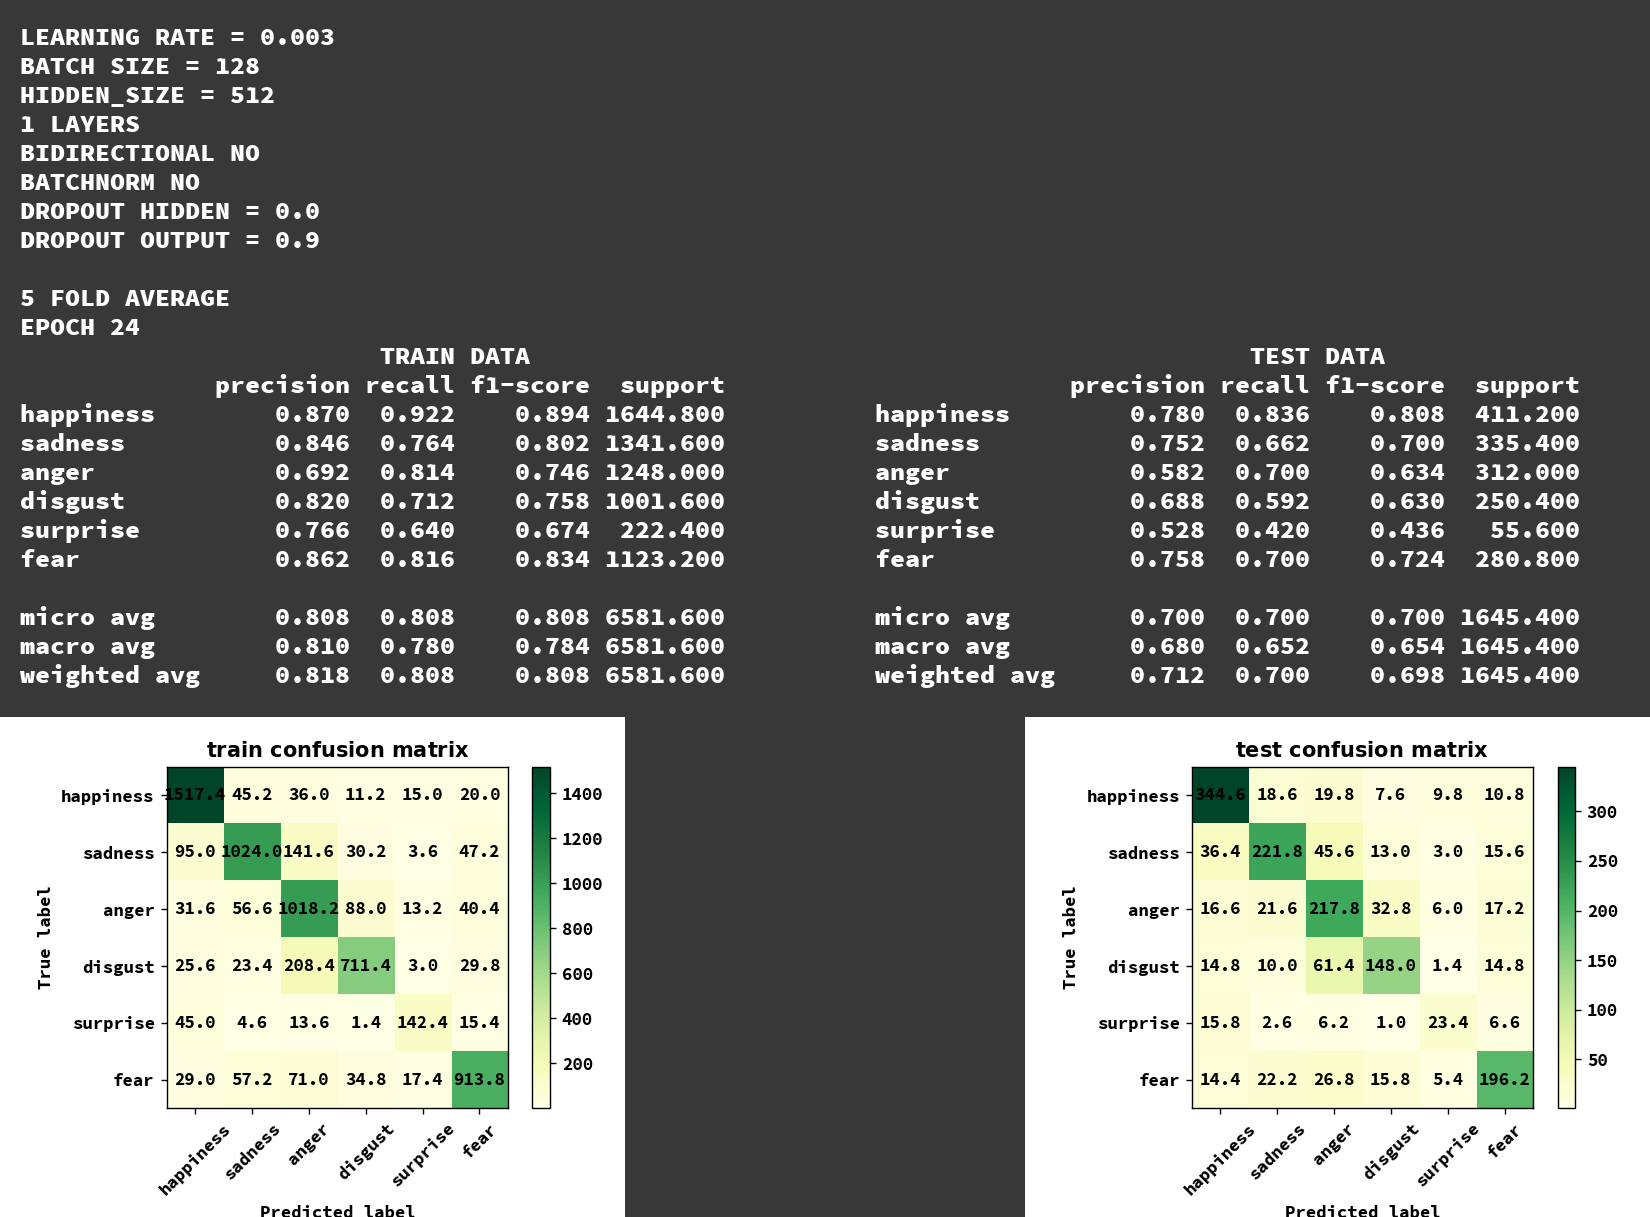

Early stopping


In [0]:
#@title Training
#torch.set_printoptions(precision=25)
iterlist = itertools.product(lrlist, batchsizelist, hdlist, lylist, bdlist, bnlist, dphlist, dpolist)

import multiprocessing as mp

for learning_rate, batch_size, hidden_size, num_layers, bidirectional, batchnorm, dropout_hidden, dropout_output in iterlist:
    if num_layers == 1 and dropout_hidden != 0.0:
        continue
    """%whos
    print("==============================")"""
    proc=mp.Process(target=train)
    proc.daemon=True
    proc.start()
    proc.join()
    """%whos
    print("==============================")"""
#torch.set_printoptions(precision=4)

#TEST ONE SENTENCE

In [0]:
#@title Create NLP Parser and Test
from nltk.parse.corenlp import CoreNLPParser
parser = CoreNLPParser(url='http://localhost:9080')

test_text = "I've found it but I've also found other tunnels."
print(list(parser.tokenize(test_text)))

['I', "'ve", 'found', 'it', 'but', 'I', "'ve", 'also', 'found', 'other', 'tunnels', '.']


In [0]:
def test_sentence():
    hidden_size = 512
    num_layers = 1
    bidirectional = False
    batchnorm = False
    dropout_hidden = 0
    dropout_output = 0.9
    model = LSTM(300, hidden_size, num_layers, bidirectional, batchnorm, dropout_hidden, dropout_output).to(device)
    
    with torch.no_grad():
        model.load_state_dict(torch.load(dirname + "models/"+ "es_n2+b128+e1000+lr0.003+hidden512+ly1+dp_h0.0+dp_o0.9.pth"))
        print(model)
        model.eval()
        test_sentence = "It's not necessarily the worst thing that could happen to me" #@param {type:"string"}
        sentence = list(parser.tokenize(test_sentence))
        input1, sent_length = ask_one(sentence, glove_used)
        class_pred = model(input1, sent_length)
        print("Sentence: " + test_sentence)
        _, pred = class_pred.max(dim=1)
        print("Prediction:\t" + emotions[pred[0]])
        print("Output Values:")
        percentages = torch.nn.functional.softmax(class_pred, dim=1) * 100
        for i in range(len(emotions)):
            print(emotions[i] + " %" + str(percentages.data.tolist()[0][i]))

import multiprocessing as mp

proc=mp.Process(target=test_sentence)
proc.daemon=True
proc.start()
proc.join()

LSTM(
  (lstm): LSTM(300, 512)
  (dropoutlayer): Dropout(p=0.9)
  (fc): Linear(in_features=512, out_features=6, bias=True)
)
Sentence: how can it be that you can always fall in all fours
Prediction:	surprise
Output Values:
happiness %13.58353042602539
sadness %14.039732933044434
anger %22.318910598754883
disgust %8.186574935913086
surprise %29.539793014526367
fear %12.331454277038574


#TEST SENTENCES

In [0]:
def test_sentences():
    hidden_size = 256
    num_layers = 1
    bidirectional = False
    batchnorm = False
    dropout_hidden = 0
    dropout_output = 0.7
    model = LSTM(300, hidden_size, num_layers, bidirectional, batchnorm, dropout_hidden, dropout_output).to(device)

    model.load_state_dict(torch.load(dirname + "models/"+ "es_n1+e100+lr0.001+hidden256+ly1+dp_h0.0+dp_o0.9.pth"))
    print(model)
    model.eval()
    happiness_sentence_1 = "" #@param {type:"string"}
    happiness_sentence_2 = "" #@param {type:"string"}
    happiness_sentence_3 = "" #@param {type:"string"}
    happiness_sentence_4 = "" #@param {type:"string"}
    happiness_sentence_5 = "" #@param {type:"string"}
    sadness_sentence_1 = "back from the pool. it sucked. started pouring down rain." #@param {type:"string"}
    sadness_sentence_2 = "Sorry I let you down guys.." #@param {type:"string"}
    sadness_sentence_3 = "going to the doctor to get my sore elbow looked after :( feel like Im getting old!" #@param {type:"string"}
    sadness_sentence_4 = "tomorrow'll be the day of \"GOODBYE\"!" #@param {type:"string"}
    sadness_sentence_5 = "i would LOVE some biscuits right now. i hate trying to loose weight :(" #@param {type:"string"}
    anger_sentence_1 = "Why are people so dumb???? Who really starts a fight at the end of the year? Locker then home studying for final:( nervous!!!" #@param {type:"string"}
    anger_sentence_2 = "I really really hate confusing weird essays about which you can find no good information!" #@param {type:"string"}
    anger_sentence_3 = "how come you were able/allowed to take pics in that bitch!?" #@param {type:"string"}
    anger_sentence_4 = "another late payment notice that I get to handle. wtf." #@param {type:"string"}
    anger_sentence_5 = "why are people so dumb???? who really starts a fight at the end of the year?" #@param {type:"string"}
    disgust_sentence_1 = "i've never met a person like you who makes me want to vomit in disgust so, so, so much. ugh." #@param {type:"string"}
    disgust_sentence_2 = "wtf... listened already 300 new trance tracks on audiojelly... except dozen world hits there's nothing to listen... unprofessional shit" #@param {type:"string"}
    disgust_sentence_3 = "" #@param {type:"string"}
    disgust_sentence_4 = "" #@param {type:"string"}
    disgust_sentence_5 = "" #@param {type:"string"}
    surprise_sentence_1 = "My history was better than expected too " #@param {type:"string"}
    surprise_sentence_2 = "Ants in your pants, darling?" #@param {type:"string"}
    surprise_sentence_3 = "She almost jumped out of her skin when she saw it." #@param {type:"string"}
    surprise_sentence_4 = "I can't believe it, wonders will never cease." #@param {type:"string"}
    surprise_sentence_5 = "wth? my cat ran in the room with scaredy cat tail looking at me like i owed her money." #@param {type:"string"}
    fear_sentence_1 = "going on down to mexico to teach a little english. i'm ready for a change, but a little nervous 'cuz of all the recent publicity." #@param {type:"string"}
    fear_sentence_2 = "being really nervous for my first guitar lesson, thats just stupid..!" #@param {type:"string"}
    fear_sentence_3 = "you get me nervous garrett." #@param {type:"string"}
    fear_sentence_4 = "drag me to hell was a mega, it's a shame the rest of the band are too scared to go and see it." #@param {type:"string"}
    fear_sentence_5 = "if they found out that i used to be one, they would be horrified." #@param {type:"string"}
    test_sentences = {}
    for emotion in ['happiness', 'sadness', 'anger', 'disgust', 'surprise', 'fear']:
        exec('test_sentences[emotion] = [' + emotion + "_sentence_1, " + \
             emotion + "_sentence_2, " + emotion + "_sentence_3, " + \
             emotion + "_sentence_4, " + emotion + "_sentence_5" +']')

    correct = 0
    false = 0
    with torch.no_grad():
        for k, v in test_sentences.items():
            if len(v) == 0:
                continue
            for test_sentence in v:
                if len(test_sentence) == 0:
                    continue
                sentence = list(parser.tokenize(test_sentence))
                input1, sent_length = ask_one(sentence, glove_used)
                class_pred = model(input1, sent_length)
                print("Sentence: " + test_sentence)
                _, pred = class_pred.max(dim=1)
                print("Truth:\t\t" + k)
                print("Prediction:\t" + emotions[pred[0]])
                if k == emotions[pred[0]]:
                    correct += 1
                else:
                    false += 1
                print("Output Values:")
                print(class_pred)
        print("True Pred: " + str(correct))
        print("False Pred: " + str(false))
proc=mp.Process(target=test_sentences)
proc.daemon=True
proc.start()
proc.join()

#FASTTEXT DATA CREATION

In [0]:
our_file_1 = dirname + "Emotion-Data/Annotated Data/annotset - filtered.txt"
our_file_2 = dirname + "Emotion-Data/Annotated Data/basefile - filtered - preprocessed.txt"
dataset = []

with open(our_file_1, "r") as file1, open(our_file_2, "r") as file2:
    for line_from_file_1, line_from_file_2 in zip(file1, file2):
        output = None
        line1 = line_from_file_1.split()
        line2 = line_from_file_2
        if line1[0] == "ne":
            output = 7
        elif line1[0] == "hp":
            output = 0
        elif line1[0] == "sd":
            output = 1
        elif line1[0] == "ag":
            output = 2
        elif line1[0] == "dg":
            output = 3
        elif line1[0] == "sp":
            output = 4
        elif line1[0] == "fr":
            output = 5
        elif line1[0] == "me":
            output = 6
        dataset.append((output, fastText.tokenize(line2)))
print(len(dataset))

4266


In [0]:
for emotion in [(1, 'sadness.txt'), (2, 'anger.txt'), (3, 'disgust.txt'), (4, 'surprise.txt'), (5, 'fear.txt')]:
    emotion_our_filename = dirname + "Emotion-Data Generated by us/" + emotion[1]
    with open(emotion_our_filename, "r") as file:
        for line in file:
            dataset.append((emotion[0], fastText.tokenize(line)))
print(len(dataset))

1384


In [0]:
import _pickle as cPickle
with open(dirname + "Pickle/s_aman data fastText", 'wb') as outfile:
    cPickle.dump(dataset, outfile)

# FAIRY TALE DATASET

In [0]:
#@title Read Dataset
import _pickle as cPickle

start_time = time.time()
with open(dirname + "Pickle/fairy tales dataset", 'rb') as infile:
    dataset = cPickle.load(infile)
print("--- %s seconds ---" % (time.time() - start_time))
print(len(dataset))

--- 0.5558562278747559 seconds ---
4266


In [0]:
#@title Dataset Shuffle
from random import shuffle
shuffle(dataset)

In [0]:
#@title Counter
counter = [0] * 8
for data in dataset:
    counter[data[0]] += 1
print(counter)

[445, 264, 218, 0, 114, 166, 0, 0]


LSTM(
  (lstm): LSTM(300, 256)
  (dropoutlayer): Dropout(p=0.7)
  (fc): Linear(in_features=256, out_features=6, bias=True)
)
tensor([1, 1, 4,  ..., 4, 0, 3])
tensor([1, 1, 2,  ..., 4, 5, 2])


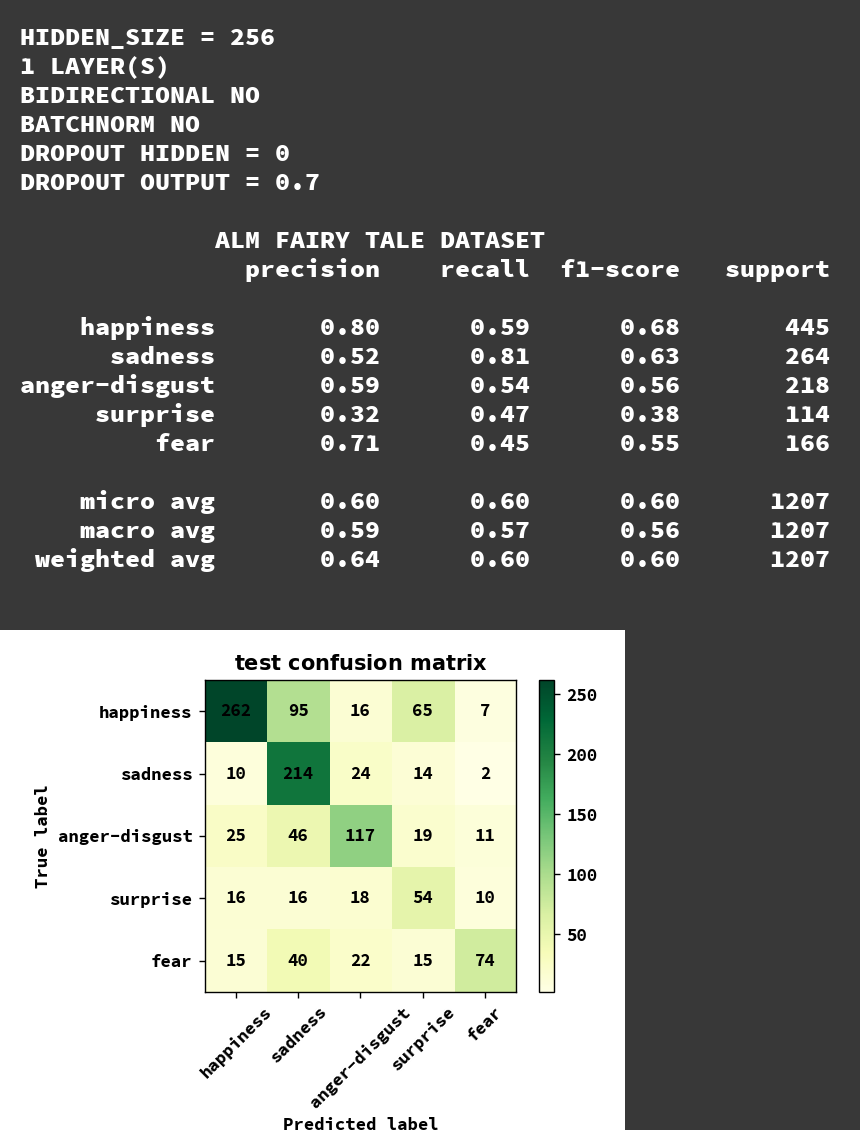

In [0]:
#@title Fairy Tale Data Test
def showResults(test, test_conf_matrix, emotions):
    text_width, text_height = getSize(test)
    img = Image.new('RGB', (text_width + 50, text_height + 50), (56, 56, 56))
    draw = ImageDraw.Draw(img)
    draw.text((20, 20), test, fill=(255, 255, 255), font=font)
        
    
    test_conf_matrix = plot_confusion_matrix(test_conf_matrix, emotions, False)
    
    test_conf_matrix.seek(0)
    test_conf_image = Image.open(test_conf_matrix)
    
    final_im = appendVertical([img, test_conf_image], 0)
    
    bio = BytesIO()
    final_im.save(bio, format='png')
    
    display.display(display.Image(bio.getvalue(), format='png', retina=True))
    bio.close()
    

def test_dataset():
    hidden_size = 256
    num_layers = 1
    bidirectional = False
    batchnorm = False
    dropout_hidden = 0
    dropout_output = 0.7
    model = LSTM(300, hidden_size, num_layers, bidirectional, batchnorm, dropout_hidden, dropout_output).to(device)
    model.load_state_dict(torch.load(dirname + "models/"+ "es_n2+b16+e1000+lr0.003+hidden256+ly1+dp_h0.0+dp_o0.7.pth"))
    print(model)
    model.eval()
    
    outputs, filelines = zip(*dataset)
    outputs = torch.LongTensor(outputs).to(device)
    
    padded_vectors, targets, sent_lengths = ready_data(outputs, filelines, True)
    
    x_test, y_test, sent_len_test = get_batch(0, len(targets), padded_vectors, targets, sent_lengths)
    
    
    ######################
    #   FIND TEST LOSS   #
    ######################
    # forward pass: compute predicted outputs by passing inputs to the model
    class_pred = model(x_test, sent_len_test)
    # calculate the loss
    _, pred = class_pred.cpu().detach().max(dim=1)
    print(pred)
    pred[pred == 3] = 2

    y_test2 = y_test.cpu()
    print(y_test2)
    classification_report = metrics.classification_report(y_true = y_test2, y_pred = pred,
                                                          target_names=['happiness', 'sadness', 'anger-disgust', 'surprise', 'fear'],
                                                          labels=[0, 1, 2, 4, 5])
    test_conf_matrix = metrics.confusion_matrix(y_true = y_test2, y_pred = pred, labels=[0, 1, 2, 4, 5])

    tobeprintedtest = ["HIDDEN_SIZE = " + str(hidden_size), str(num_layers) + " LAYER(S)",
                       "BIDIRECTIONAL " + ("YES" if bidirectional else "NO"),
                       "BATCHNORM " + ("YES" if batchnorm else "NO"),
                       "DROPOUT HIDDEN = " + str(dropout_hidden),
                       "DROPOUT OUTPUT = " + str(dropout_output),
                       "", "             ALM FAIRY TALE DATASET",
                       classification_report]
    tobeprintedtest = '\n'.join(tobeprintedtest)

    
    showResults(tobeprintedtest, test_conf_matrix, ['happiness', 'sadness', 'anger-disgust', 'surprise', 'fear'])

import multiprocessing as mp
    
proc=mp.Process(target=test_dataset)
proc.daemon=True
proc.start()
proc.join()

# FAIRY TALE DATASET 4 CATEGORIES

In [0]:
#@title Read Dataset
import _pickle as cPickle

start_time = time.time()
with open(dirname + "Pickle/fairy tales dataset", 'rb') as infile:
    dataset = cPickle.load(infile)
print("--- %s seconds ---" % (time.time() - start_time))
print(len(dataset))

--- 0.014284133911132812 seconds ---
4266


In [0]:
#@title Dataset Shuffle
from random import shuffle
shuffle(dataset)

In [0]:
#@title Counter & Filter
counter = [0] * 8
filtereddata = []
for data in dataset:
    counter[data[0]] += 1
    if data[0] == 4:
        continue
    filtereddata.append(data)
print(len(filtereddata))
print(counter)

1093
[445, 264, 218, 0, 114, 166, 0, 0]


LSTM(
  (lstm): LSTM(300, 256)
  (dropoutlayer): Dropout(p=0.7)
  (fc): Linear(in_features=256, out_features=6, bias=True)
)
tensor([1, 1, 4,  ..., 0, 3, 2])
tensor([1, 1, 2,  ..., 5, 2, 2])


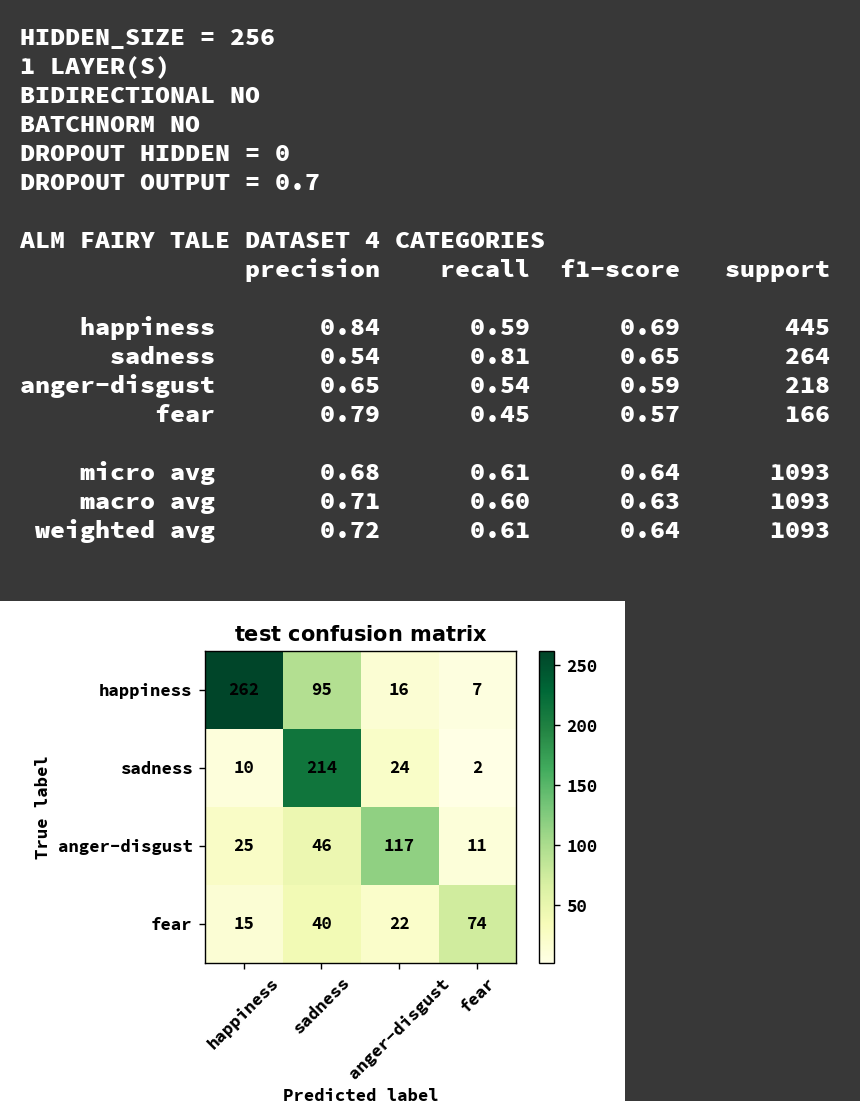

In [0]:
#@title Fairy Tale Data Test 4 Categories
def showResults(test, test_conf_matrix, emotions):
    text_width, text_height = getSize(test)
    img = Image.new('RGB', (text_width + 50, text_height + 50), (56, 56, 56))
    draw = ImageDraw.Draw(img)
    draw.text((20, 20), test, fill=(255, 255, 255), font=font)
        
    
    test_conf_matrix = plot_confusion_matrix(test_conf_matrix, emotions, False)
    
    test_conf_matrix.seek(0)
    test_conf_image = Image.open(test_conf_matrix)
    
    final_im = appendVertical([img, test_conf_image], 0)
    
    bio = BytesIO()
    final_im.save(bio, format='png')
    
    display.display(display.Image(bio.getvalue(), format='png', retina=True))
    bio.close()
    

def test_dataset():
    hidden_size = 256
    num_layers = 1
    bidirectional = False
    batchnorm = False
    dropout_hidden = 0
    dropout_output = 0.7
    model = LSTM(300, hidden_size, num_layers, bidirectional, batchnorm, dropout_hidden, dropout_output).to(device)
    model.load_state_dict(torch.load(dirname + "models/"+ "es_n2+b16+e1000+lr0.003+hidden256+ly1+dp_h0.0+dp_o0.7.pth"))
    print(model)
    model.eval()
    
    outputs, filelines = zip(*filtereddata)
    outputs = torch.LongTensor(outputs).to(device)
    
    padded_vectors, targets, sent_lengths = ready_data(outputs, filelines, True)
    
    x_test, y_test, sent_len_test = get_batch(0, len(targets), padded_vectors, targets, sent_lengths)
    
    
    ######################
    #   FIND TEST LOSS   #
    ######################
    # forward pass: compute predicted outputs by passing inputs to the model
    class_pred = model(x_test, sent_len_test)
    # calculate the loss
    _, pred = class_pred.cpu().detach().max(dim=1)
    print(pred)
    pred[pred == 3] = 2

    y_test2 = y_test.cpu()
    print(y_test2)
    classification_report = metrics.classification_report(y_true = y_test2, y_pred = pred,
                                                          target_names=['happiness', 'sadness', 'anger-disgust', 'fear'],
                                                          labels=[0, 1, 2, 5])
    test_conf_matrix = metrics.confusion_matrix(y_true = y_test2, y_pred = pred, labels=[0, 1, 2, 5])

    tobeprintedtest = ["HIDDEN_SIZE = " + str(hidden_size), str(num_layers) + " LAYER(S)",
                       "BIDIRECTIONAL " + ("YES" if bidirectional else "NO"),
                       "BATCHNORM " + ("YES" if batchnorm else "NO"),
                       "DROPOUT HIDDEN = " + str(dropout_hidden),
                       "DROPOUT OUTPUT = " + str(dropout_output),
                       "", "ALM FAIRY TALE DATASET 4 CATEGORIES",
                       classification_report]
    tobeprintedtest = '\n'.join(tobeprintedtest)

    
    showResults(tobeprintedtest, test_conf_matrix, ['happiness', 'sadness', 'anger-disgust', 'fear'])

import multiprocessing as mp
    
proc=mp.Process(target=test_dataset)
proc.daemon=True
proc.start()
proc.join()

#ISEAR DATASET

In [0]:
#@title Read Dataset
import _pickle as cPickle

start_time = time.time()
with open(dirname + "Pickle/ISEAR dataset", 'rb') as infile:
    dataset = cPickle.load(infile)
print("--- %s seconds ---" % (time.time() - start_time))
print(len(dataset))

--- 0.6703624725341797 seconds ---
4266


In [0]:
#@title Dataset Shuffle
from random import shuffle
shuffle(dataset)

In [0]:
#@title Counter
counter = [0] * 8
for data in dataset:
    counter[data[0]] += 1
print(counter)

[1075, 1066, 1070, 1067, 0, 1079, 0, 0]


In [0]:
#@title Snip gloveModel because we do not have enough RAM
outputs, filelines = zip(*dataset)
minigloveModel = {}

for line in filelines:
    for word in line:
        if word in gloveModel:
            minigloveModel[word] = gloveModel[word]

gloveModel = minigloveModel

LSTM(
  (lstm): LSTM(300, 256)
  (dropoutlayer): Dropout(p=0.7)
  (fc): Linear(in_features=256, out_features=6, bias=True)
)
tensor([2, 0, 0,  ..., 2, 2, 2])
tensor([3, 0, 3,  ..., 5, 3, 2])


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


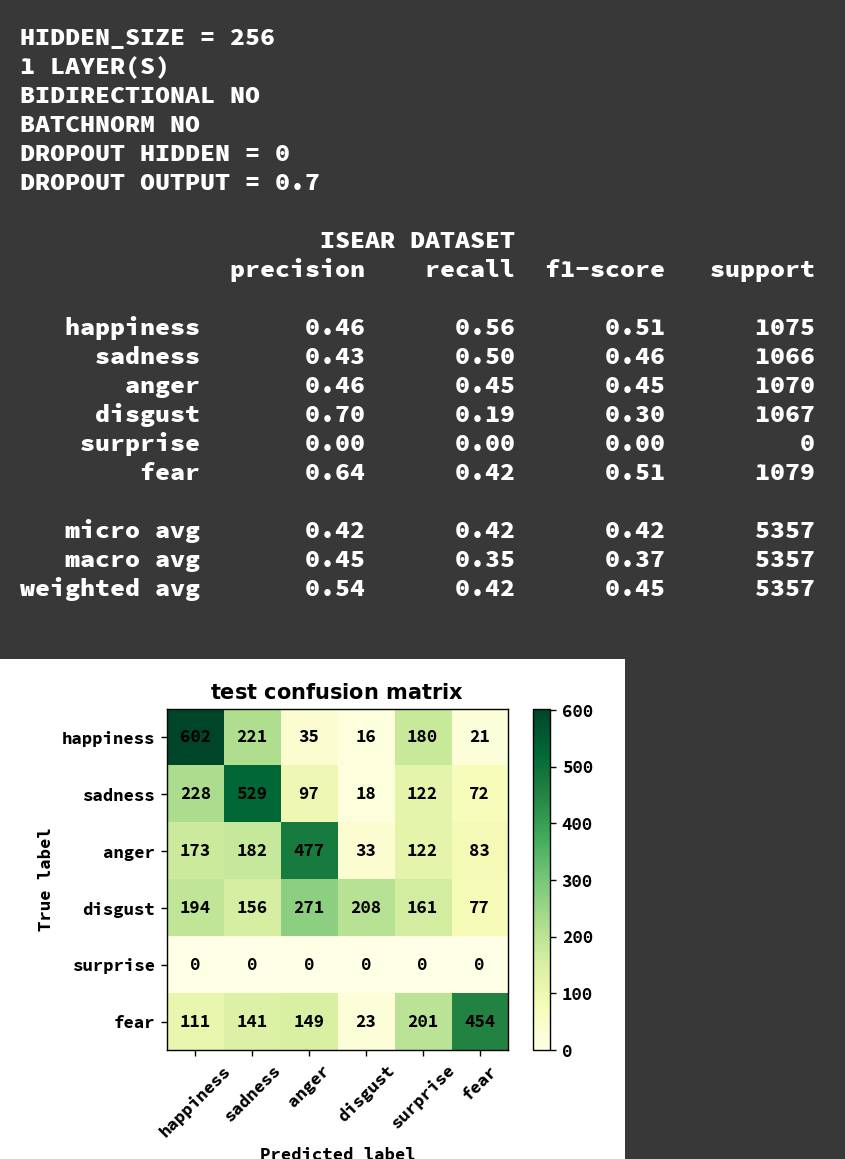

In [0]:
#@title ISEAR Data Test
def showResults(test, test_conf_matrix, emotions):
    text_width, text_height = getSize(test)
    img = Image.new('RGB', (text_width + 50, text_height + 50), (56, 56, 56))
    draw = ImageDraw.Draw(img)
    draw.text((20, 20), test, fill=(255, 255, 255), font=font)
        
    
    test_conf_matrix = plot_confusion_matrix(test_conf_matrix, emotions, False)
    
    test_conf_matrix.seek(0)
    test_conf_image = Image.open(test_conf_matrix)
    
    final_im = appendVertical([img, test_conf_image], 0)
    
    bio = BytesIO()
    final_im.save(bio, format='png')
    
    display.display(display.Image(bio.getvalue(), format='png', retina=True))
    bio.close()
    

def test_dataset():
    hidden_size = 256
    num_layers = 1
    bidirectional = False
    batchnorm = False
    dropout_hidden = 0
    dropout_output = 0.7
    model = LSTM(300, hidden_size, num_layers, bidirectional, batchnorm, dropout_hidden, dropout_output).to(device)
    model.load_state_dict(torch.load(dirname + "models/"+ "es_n2+b16+e1000+lr0.003+hidden256+ly1+dp_h0.0+dp_o0.7.pth"))
    print(model)
    model.eval()
    
    outputs, filelines = zip(*dataset)
    outputs = torch.LongTensor(outputs).to(device)
    
    padded_vectors, targets, sent_lengths = ready_data(outputs, filelines, True)
    
    x_test, y_test, sent_len_test = get_batch(0, len(targets), padded_vectors, targets, sent_lengths)
    
    
    ######################
    #   FIND TEST LOSS   #
    ######################
    # forward pass: compute predicted outputs by passing inputs to the model
    class_pred = model(x_test, sent_len_test)
    # calculate the loss
    _, pred = class_pred.cpu().detach().max(dim=1)
    print(pred)

    y_test2 = y_test.cpu()
    print(y_test2)
    classification_report = metrics.classification_report(y_true = y_test2, y_pred = pred,
                                                          target_names=['happiness', 'sadness', 'anger', 'disgust', 'surprise', 'fear'],
                                                          labels=[0, 1, 2, 3, 4, 5])
    test_conf_matrix = metrics.confusion_matrix(y_true = y_test2, y_pred = pred, labels=[0, 1, 2, 3, 4, 5])

    tobeprintedtest = ["HIDDEN_SIZE = " + str(hidden_size), str(num_layers) + " LAYER(S)",
                       "BIDIRECTIONAL " + ("YES" if bidirectional else "NO"),
                       "BATCHNORM " + ("YES" if batchnorm else "NO"),
                       "DROPOUT HIDDEN = " + str(dropout_hidden),
                       "DROPOUT OUTPUT = " + str(dropout_output),
                       "", "                    ISEAR DATASET",
                       classification_report]
    tobeprintedtest = '\n'.join(tobeprintedtest)

    
    showResults(tobeprintedtest, test_conf_matrix, ['happiness', 'sadness', 'anger', 'disgust', 'surprise', 'fear'])

import multiprocessing as mp
    
proc=mp.Process(target=test_dataset)
proc.daemon=True
proc.start()
proc.join()